In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import nltk
import string

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


###1.  Importing Dataset 1

In [2]:
train_df = pd.read_csv("https://github.com/diptamath/covid_fake_news/raw/main/data/Constraint_Train.csv")
val_df = pd.read_csv("https://github.com/diptamath/covid_fake_news/raw/main/data/Constraint_Val.csv")
test_df = pd.read_csv("https://github.com/diptamath/covid_fake_news/raw/main/data/english_test_with_labels.csv")
df_1 = pd.concat([train_df, val_df, test_df])

df_1['label'] = df_1['label'].replace({'real': 0, 'fake': 1})

In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 334.4+ KB


###2. Importing Dataset 2 'CoAID'

In [4]:
fake_news1 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/05-01-2020/NewsFakeCOVID-19.csv")
fake_news2 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/07-01-2020/NewsFakeCOVID-19.csv")
fake_news3 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/09-01-2020/NewsFakeCOVID-19.csv")
fake_news4 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/11-01-2020/NewsFakeCOVID-19.csv")

fake_news = pd.concat([fake_news1, fake_news2, fake_news3, fake_news4])

fake_news_df = fake_news[['title']]
fake_news_df['label'] = 1

true_news1 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/05-01-2020/NewsRealCOVID-19.csv")
true_news2 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/07-01-2020/NewsRealCOVID-19.csv")
true_news3 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/09-01-2020/NewsRealCOVID-19.csv")
true_news4 = pd.read_csv("https://github.com/cuilimeng/CoAID/raw/master/11-01-2020/NewsRealCOVID-19.csv")

true_news = pd.concat([true_news1, true_news2, true_news3, true_news4])

true_news_df = true_news[['title']]
true_news_df['label'] = 0

df_2 = pd.concat([true_news_df, fake_news_df])

<ipython-input-4-8d7987019e8a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_df['label'] = 1
<ipython-input-4-8d7987019e8a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_news_df['label'] = 0


In [5]:
df_2 = df_2.sample(frac=1).reset_index(drop=True)

In [6]:
df_2.head(200)

title  label
0    Tiny airborne particles may carry the new coro...      0
1    Biden campaign claims a top CDC official was Ò...      1
2    'No evidence' that vitamin D can prevent or tr...      0
3    Interim Guidance on Unsheltered Homelessness a...      0
4    Scientists discover genetic and immunologic un...      0
..                                                 ...    ...
195  Disney World Reopens as Florida COVID-19 Cases...      0
196              Clinical Mitigation (Non-US Settings)      0
197  Walgreens to Open Doctor Offices: What This Me...      0
198  Masks are dirty and cause bacterial overgrowth...      1
199  US Homeland Security mobilizing National Guard...      1

[200 rows x 2 columns]

###3. Pré-processamento

####3.1. Remoção de URLs

In [7]:
def remove_urls(dataframe, column_name):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    dataframe[column_name] = dataframe[column_name].apply(lambda x: url_pattern.sub(r'', str(x)))
    return dataframe

In [8]:
df_1 = remove_urls(df_1, 'tweet')
df_2 = remove_urls(df_2, 'title')

####3.2. Remoção de pontuação

In [9]:
def remove_punctuation(dataframe, column_name):
    # dataframe[column_name] = dataframe[column_name].apply(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x)))
    return dataframe

In [10]:
df_1 = remove_punctuation(df_1, 'tweet')
df_2 = remove_punctuation(df_2, 'title')

####3.3. Remoção de emojis

In [11]:
# def remove_emojis(dataframe, column_name):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                             u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
#                             u"\U0001F680-\U0001F6FF"  # transporte e mapa de caracteres
#                             u"\U0001F700-\U0001F77F"  # alquimia, transportes, e símbolos religiosos
#                             u"\U0001F780-\U0001F7FF"  # símbolos geométricos
#                             u"\U0001F800-\U0001F8FF"  # suplemento de símbolos
#                             u"\U0001F900-\U0001F9FF"  # emoticons e personagens suplementares
#                             u"\U0001FA00-\U0001FA6F"  # emoticons suplementares
#                             u"\U0001FA70-\U0001FAFF"  # alimentos suplementares
#                             u"\U00002702-\U000027B0"  # emoticons diversos
#                             u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     dataframe[column_name] = dataframe[column_name].apply(lambda x: emoji_pattern.sub(r'', str(x)))
#     return dataframe

In [12]:
# df_1 = remove_emojis(df_1, 'tweet')
# df_2 = remove_emojis(df_2, 'title')

####3.4. Lower casing

In [13]:
df_1['tweet'] = df_1['tweet'].str.lower()
df_2['title'] = df_2['title'].str.lower()

####3.5. Remoção de stop words

In [14]:
stopwords_list = set(stopwords.words('english'))
def remove_stopwords(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].apply(lambda x: " ".join([word for word in str(x).split() if word not in stopwords_list]))
    return dataframe

In [15]:
df_1 = remove_stopwords(df_1, 'tweet')
df_2 = remove_stopwords(df_2, 'title')

####3.6. Lematização

In [16]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].apply(lambda x: lemmatize_words(str(x)))
    return dataframe

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [17]:
df_1 = lemmatize(df_1, 'tweet');
df_2 = lemmatize(df_2, 'title');

###4. Visualização de dados

In [18]:
real_news_df_1 = df_1[df_1['label'] == 0]['tweet']
fake_news_df_1 = df_1[df_1['label'] == 1]['tweet']

text_real_news_df_1 = ' '.join(real_news_df_1)
text_fake_news_df_1 = ' '.join(fake_news_df_1)

text_df_1 = ' '.join(df_1['tweet'])

real_news_df_2 = df_2.loc[df_2['label'] == 0, 'title']
fake_news_df_2 = df_2.loc[df_2['label'] == 1, 'title']

text_real_news_df_2 = ' '.join(real_news_df_2)
text_fake_news_df_2 = ' '.join(fake_news_df_2)

text_df_2 = ' '.join(df_2['title'])

In [ ]:
print(text_df_1)

####4.1. Word cloud

#####4.1.1 Dataset 1

######4.1.1.1 Real news

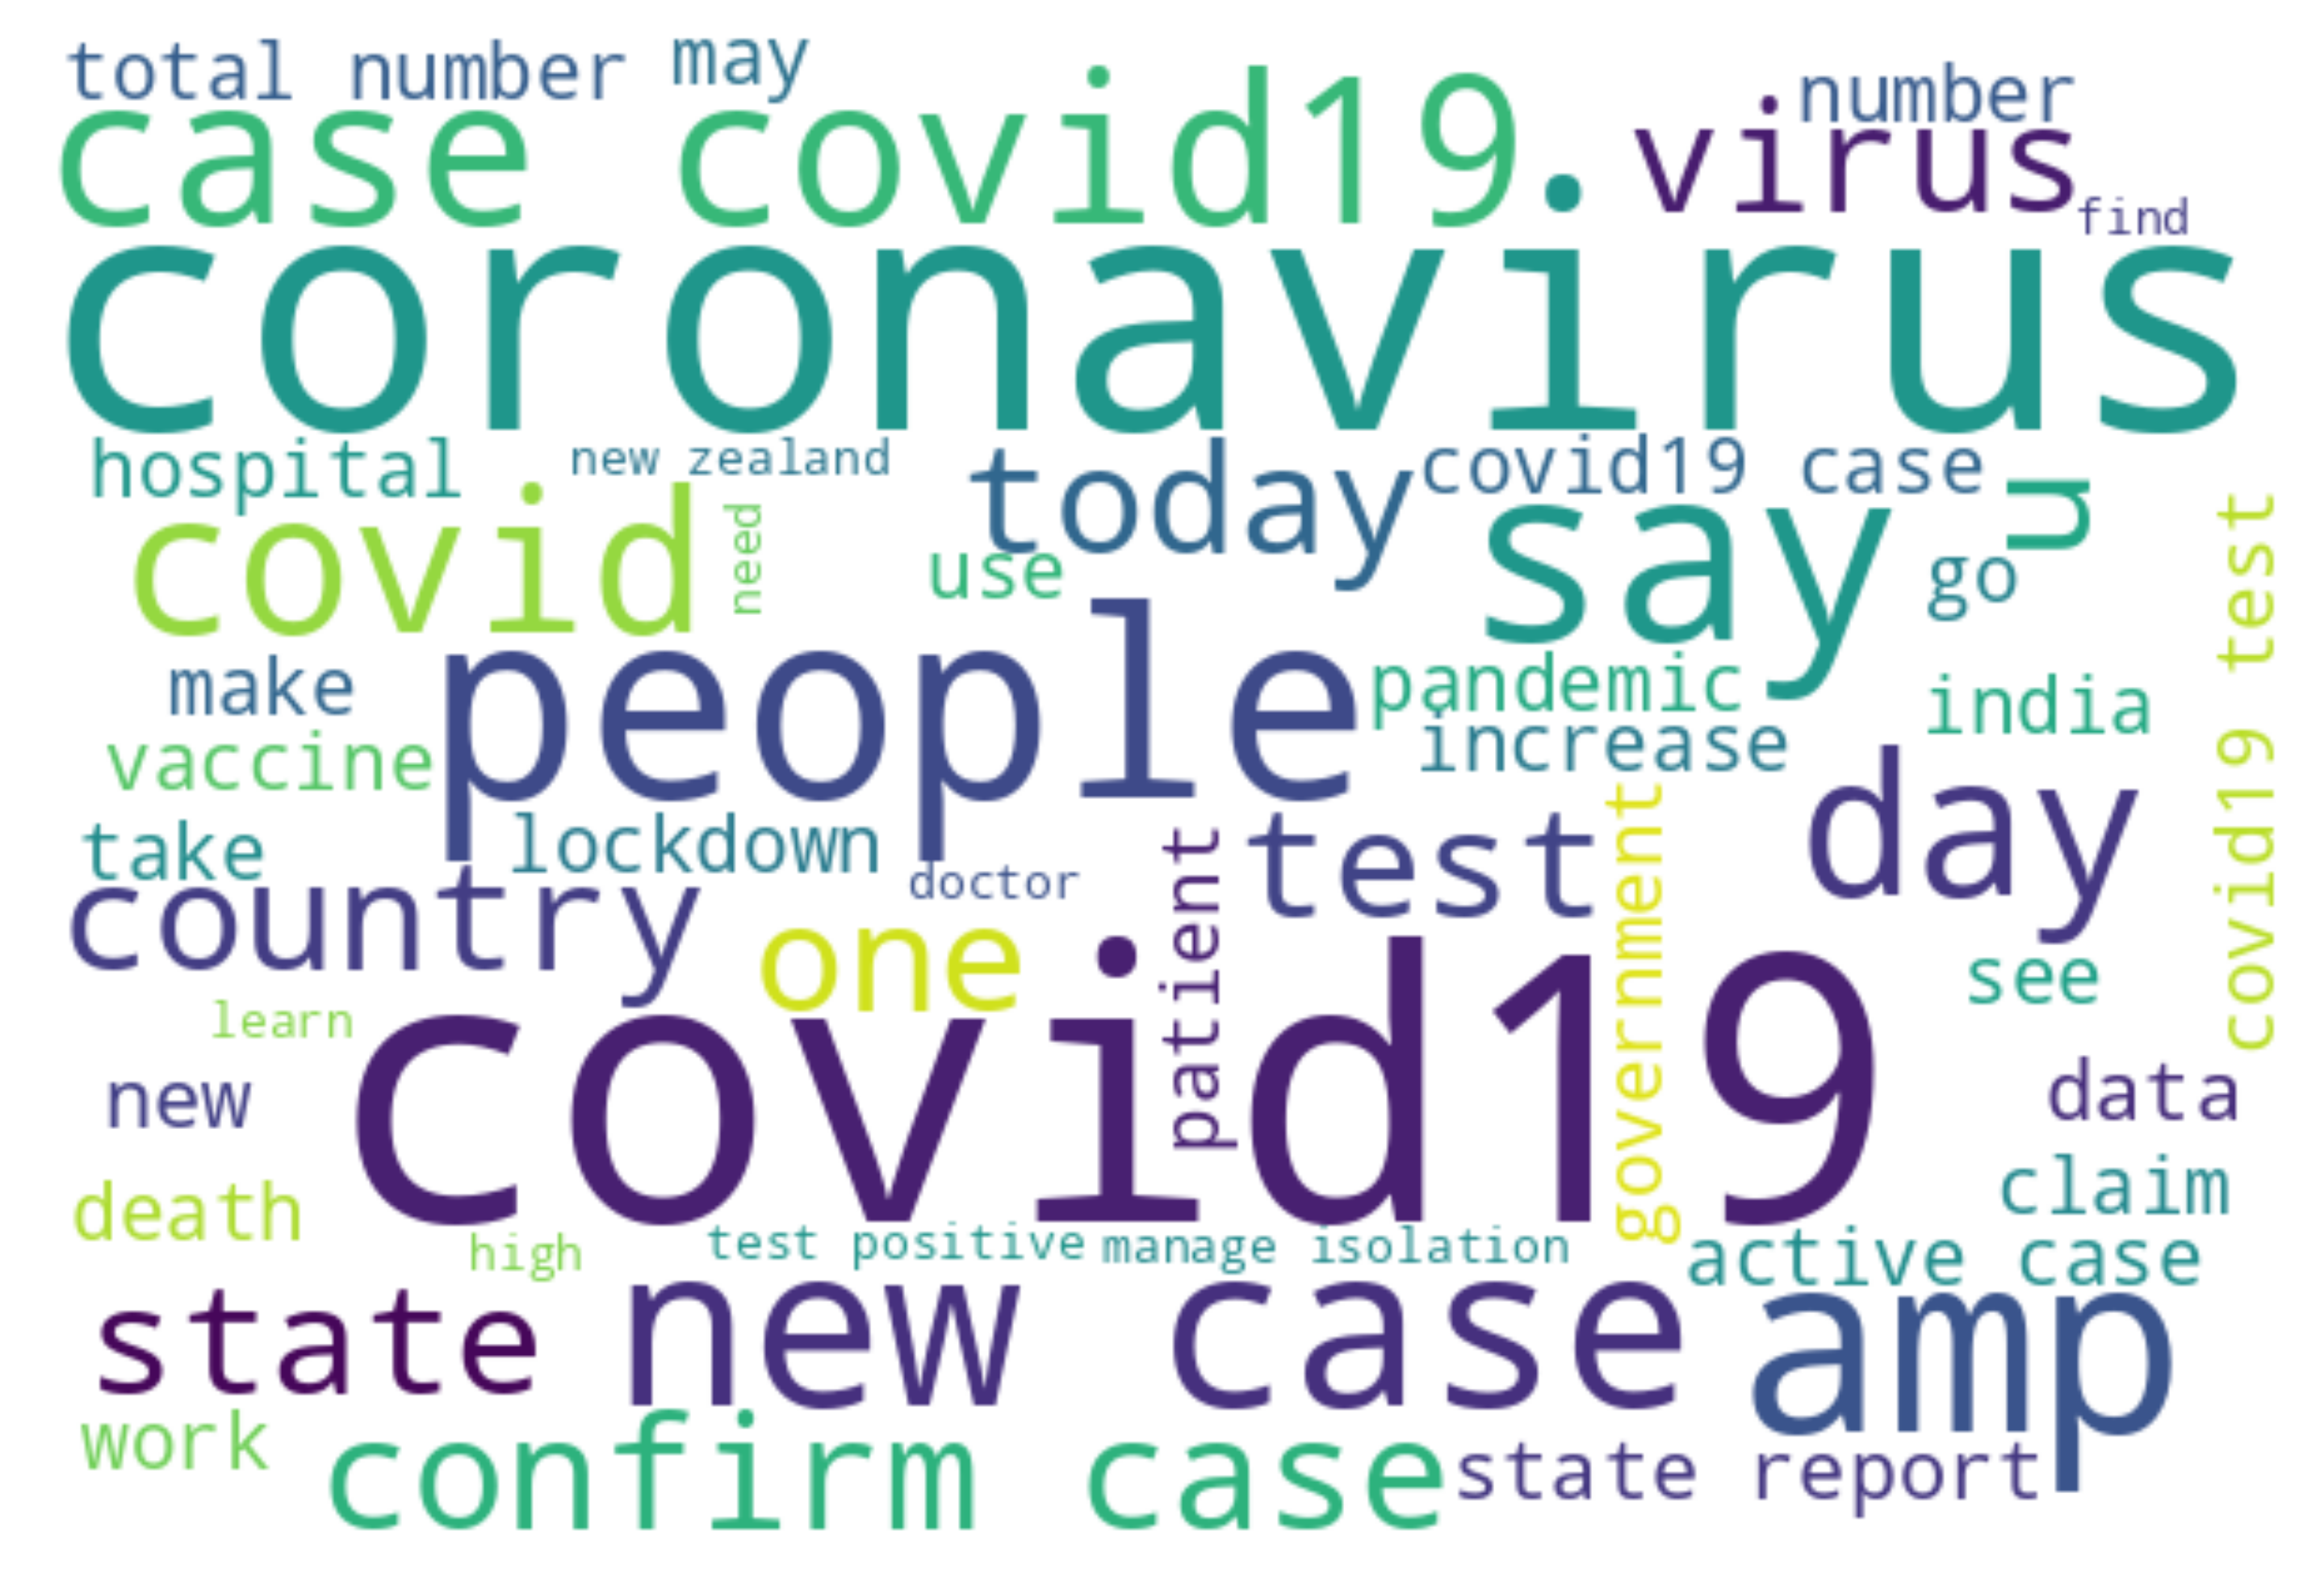

In [31]:
wordcloud = WordCloud(width=600, height=400, max_font_size=100, max_words=50, background_color="white").generate(text_df_1)
plt.figure(figsize=(8, 8), dpi=450)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

######4.1.1.2 Fake news

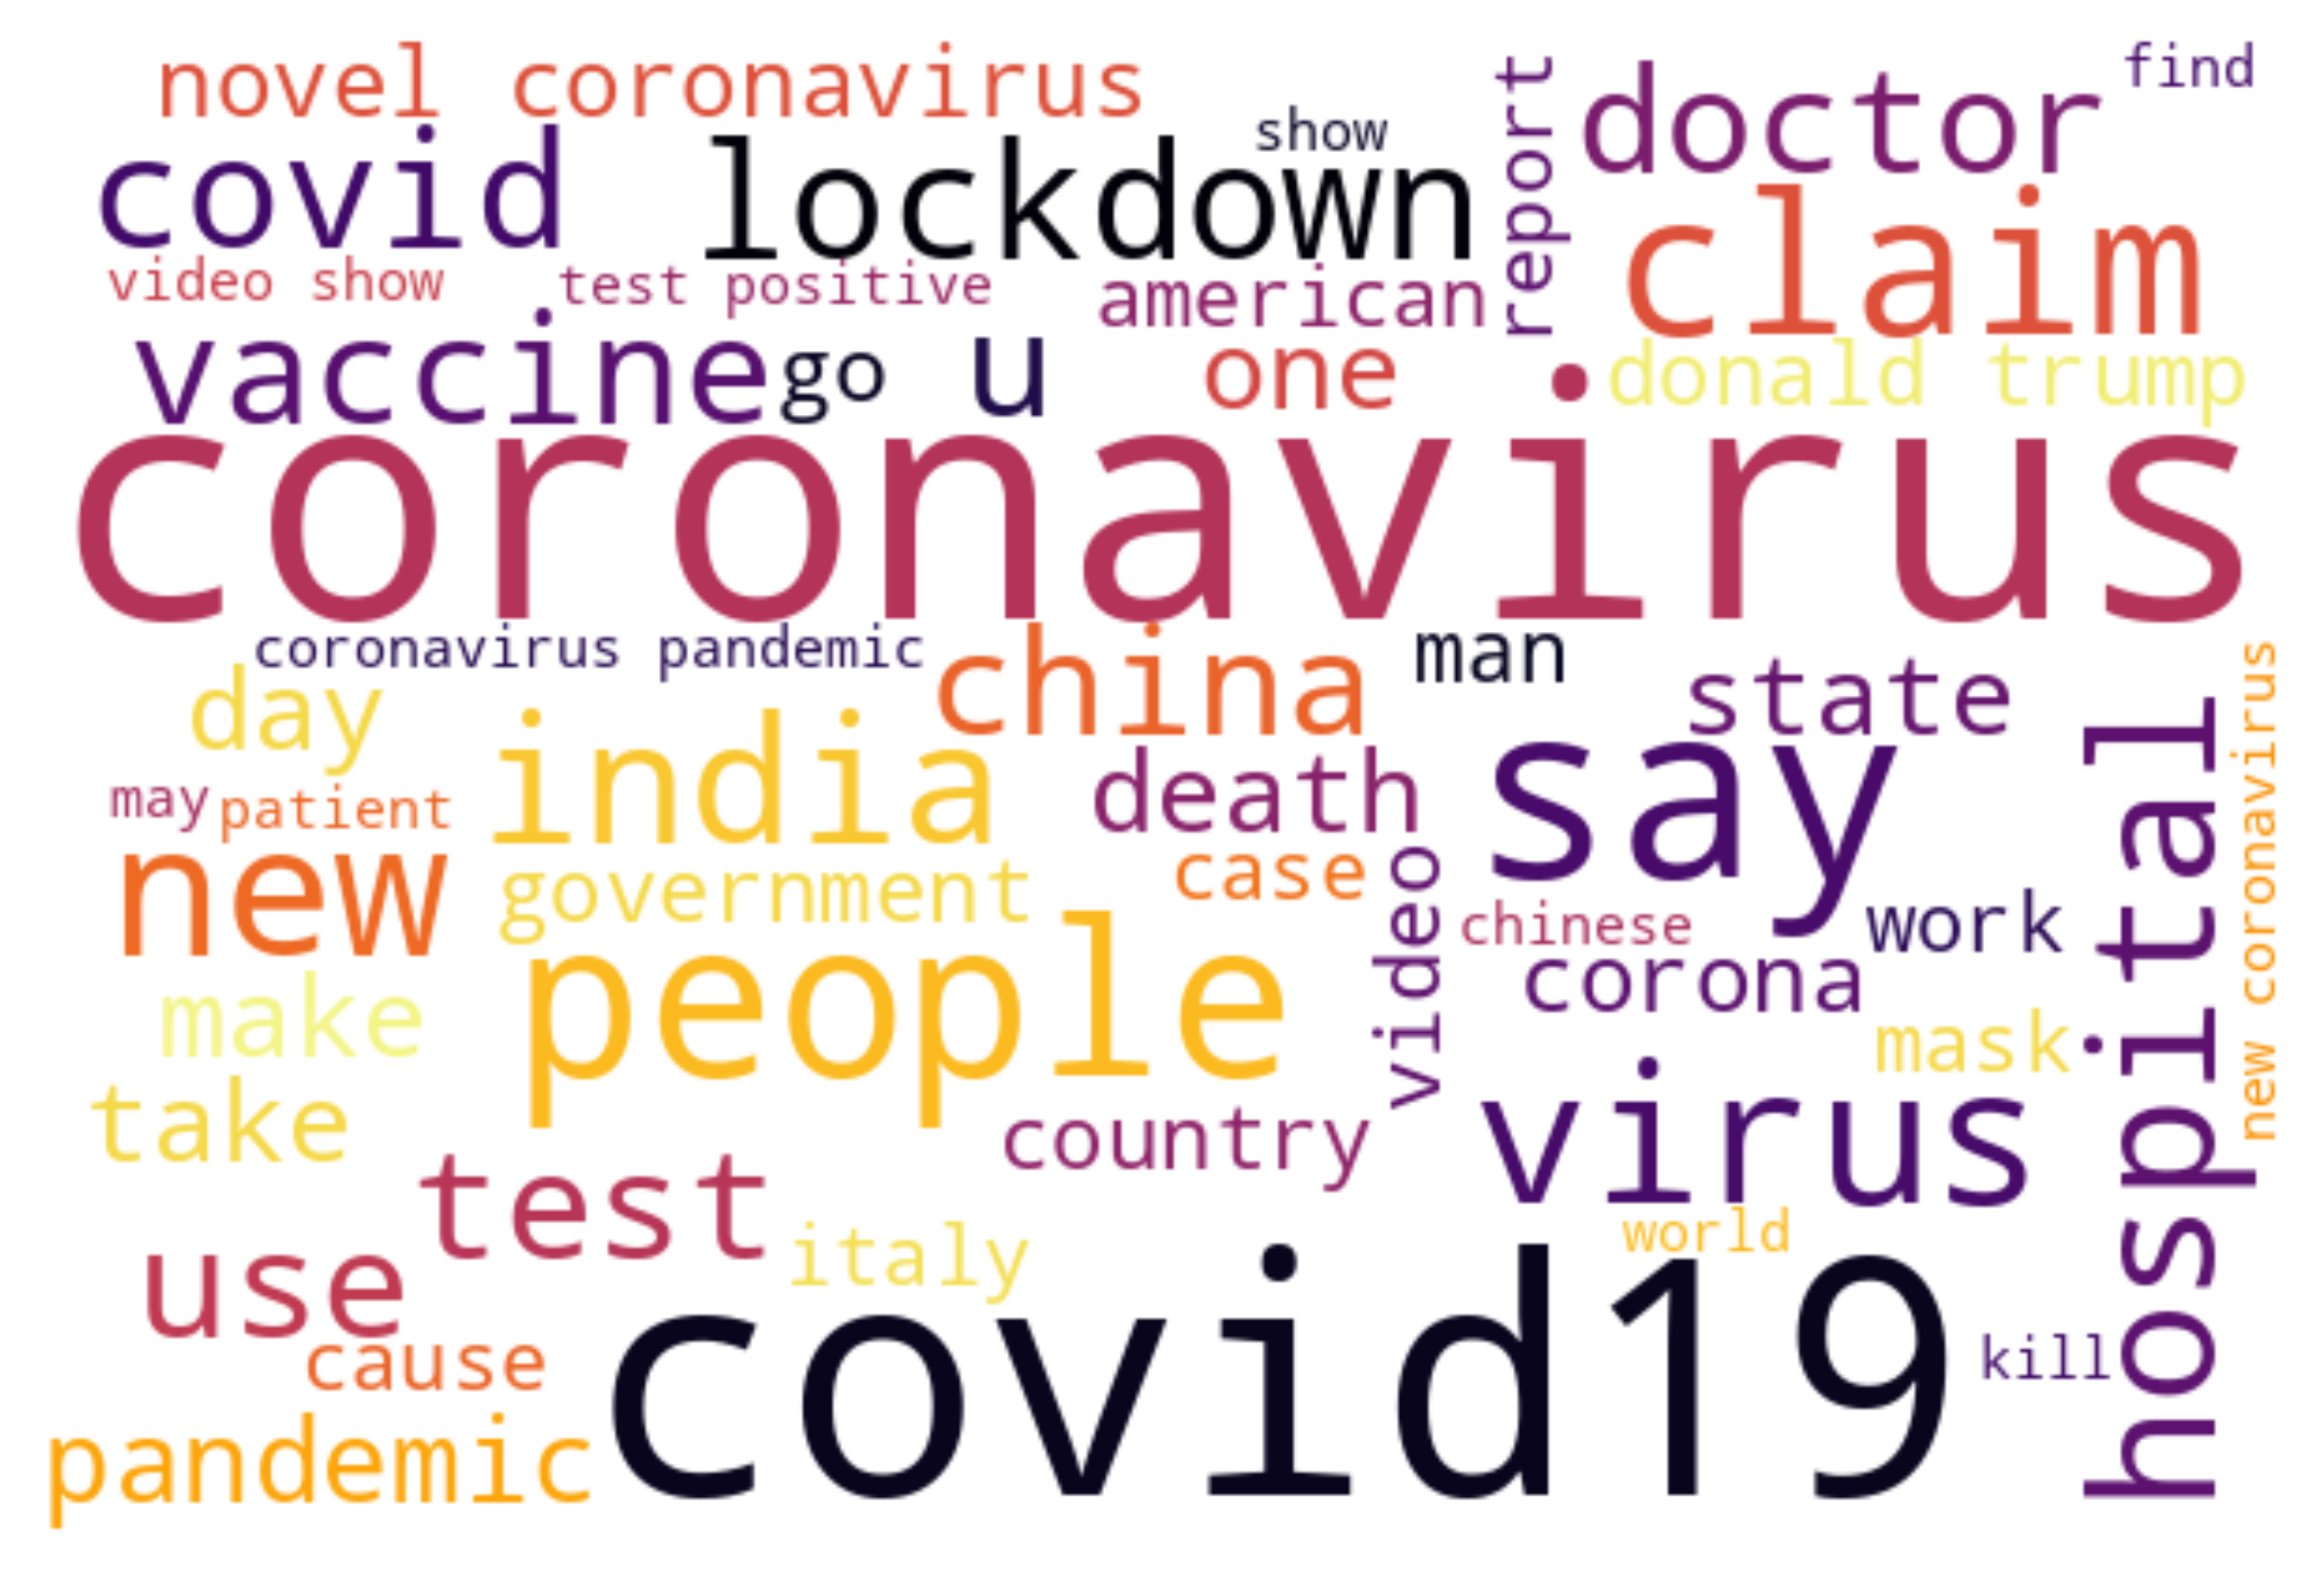

In [32]:
wordcloud = WordCloud(width=600, height=400, max_font_size=100, max_words=50, background_color="white", colormap="inferno").generate(text_fake_news_df_1)
plt.figure(figsize=(10, 5), dpi=450)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#####4.1.2 Dataset 2

In [27]:
real_news_df_2 = df_2[df_2['label'] == 0]['title']
fake_news_df_2 = df_2[df_2['label'] == 1]['title']

text_real_news_df_2 = ' '.join(real_news_df_2)
text_fake_news_df_2 = ' '.join(fake_news_df_2)

######4.1.2.1 Real news

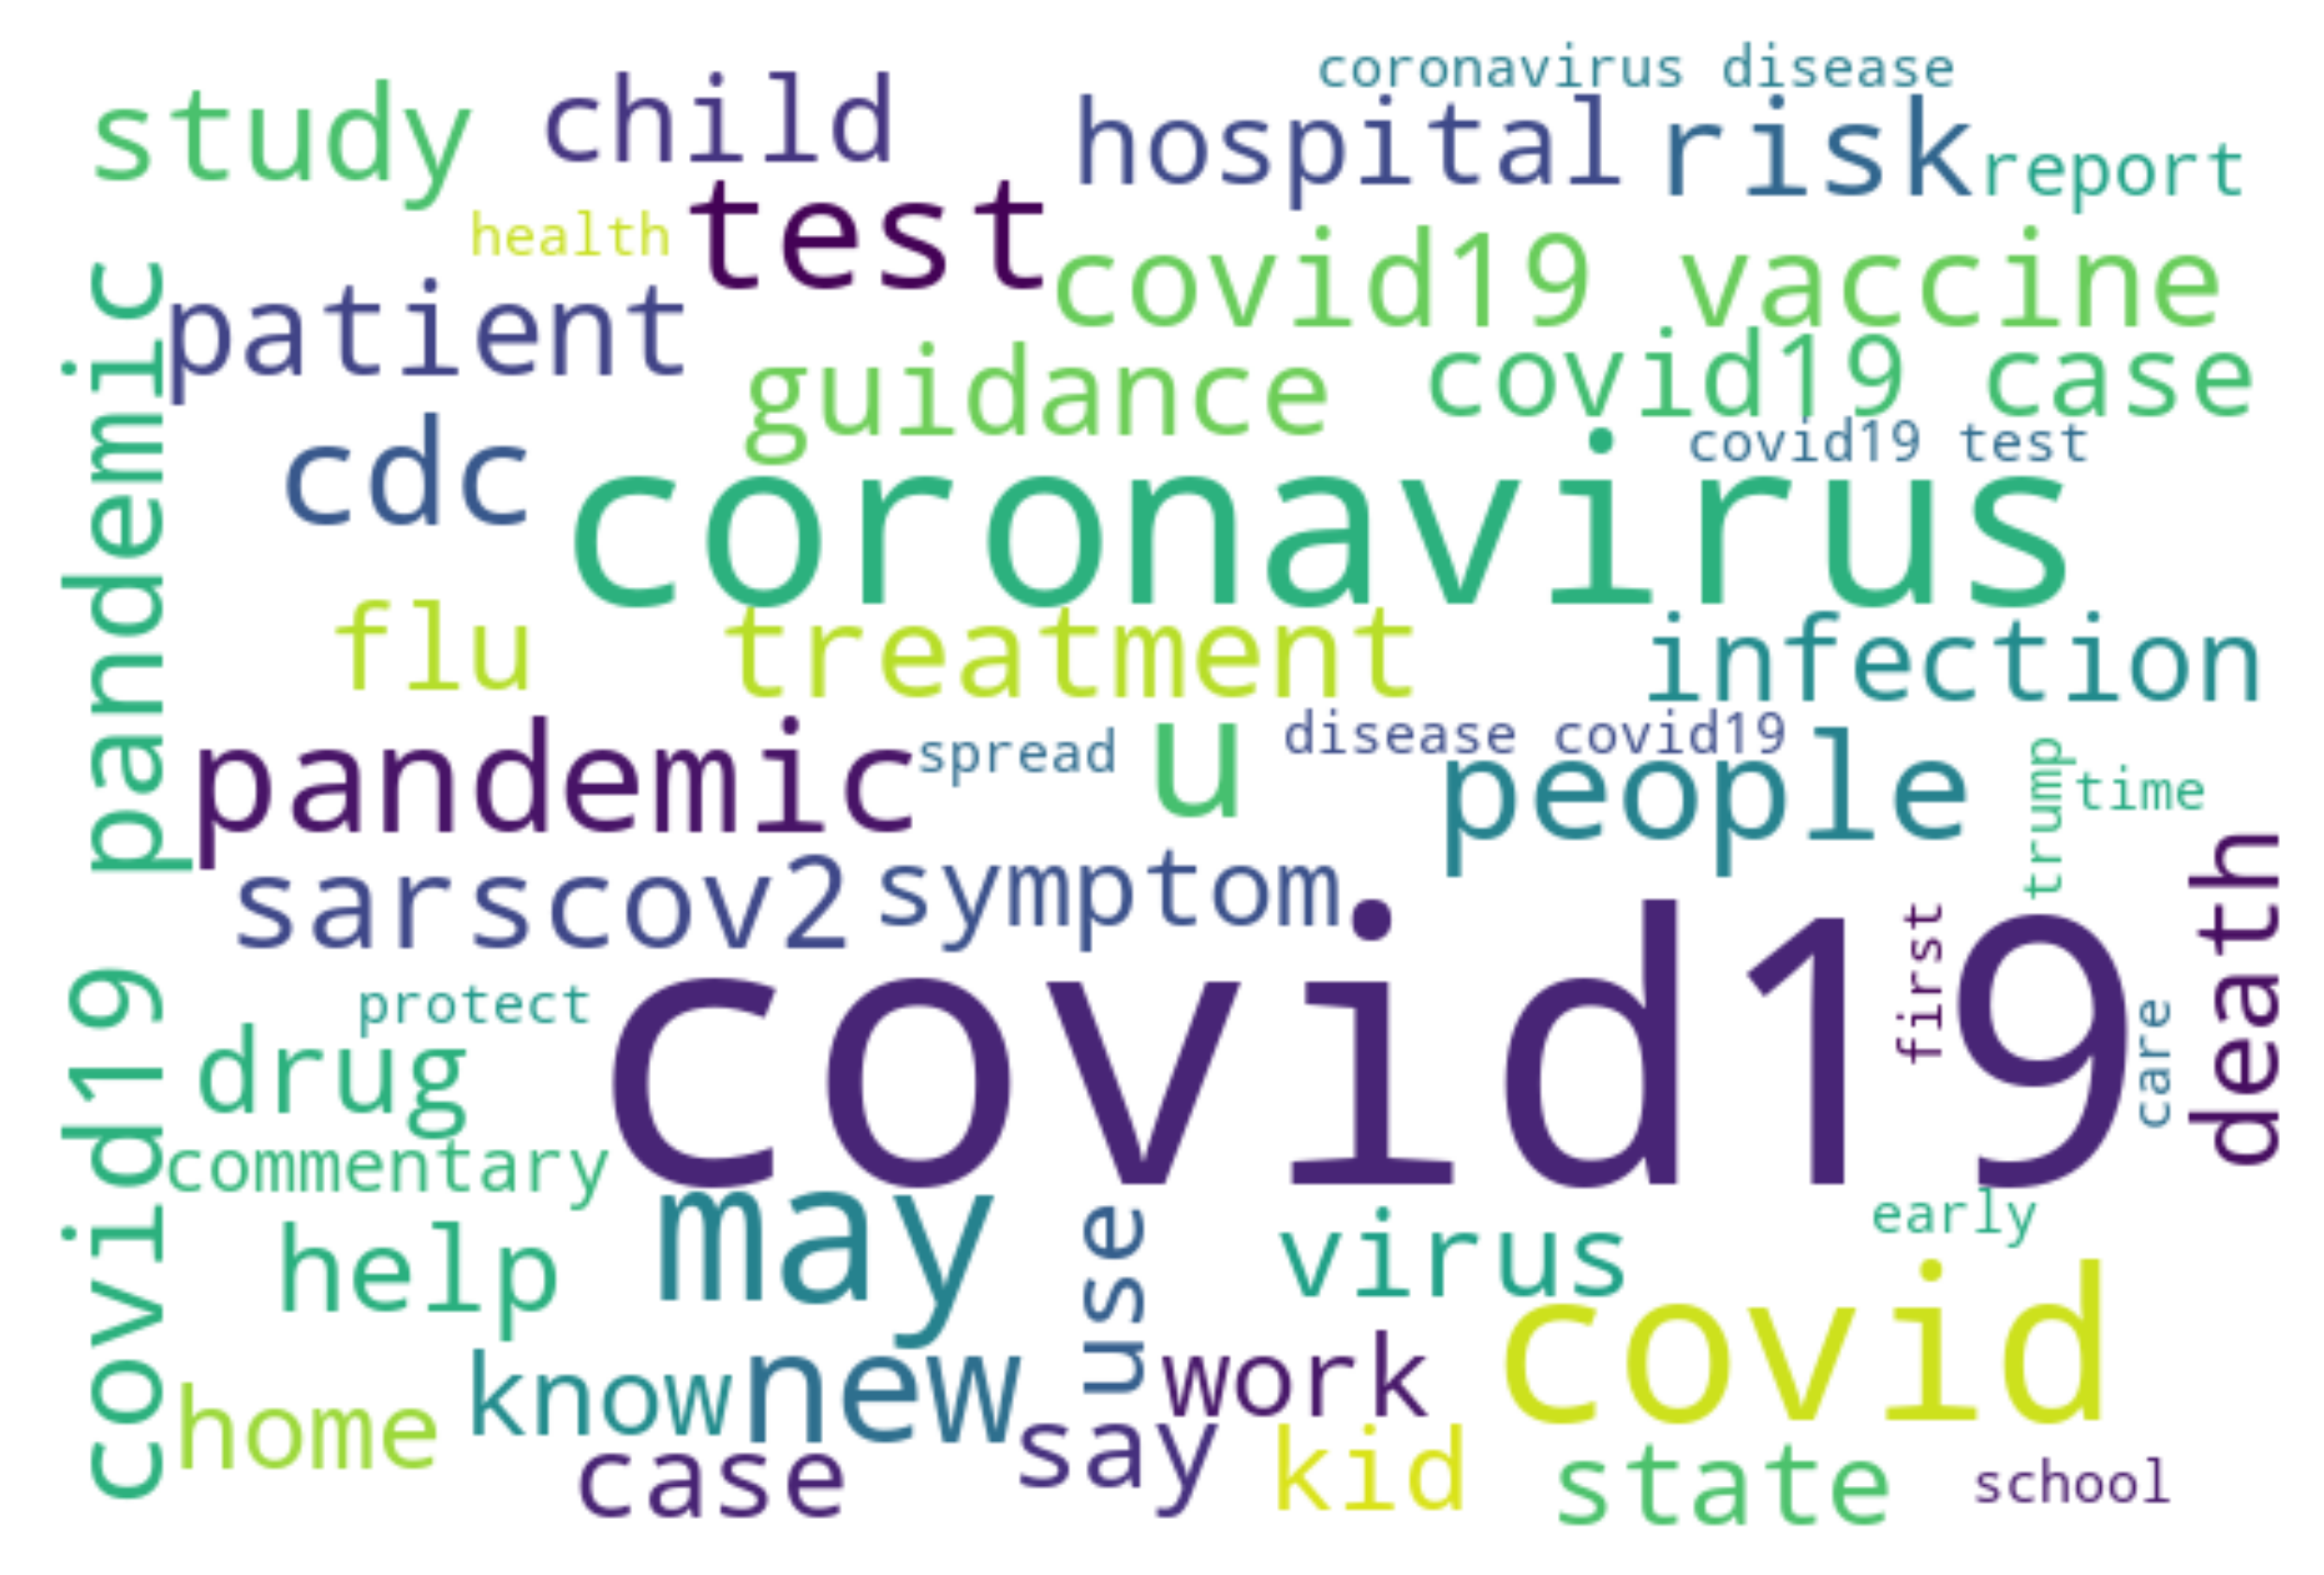

In [33]:
wordcloud = WordCloud(width=600, height=400, max_font_size=100, max_words=50, background_color="white").generate(text_real_news_df_2)
plt.figure(figsize=(10, 5), dpi=450)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

######4.1.2.2 Fake news

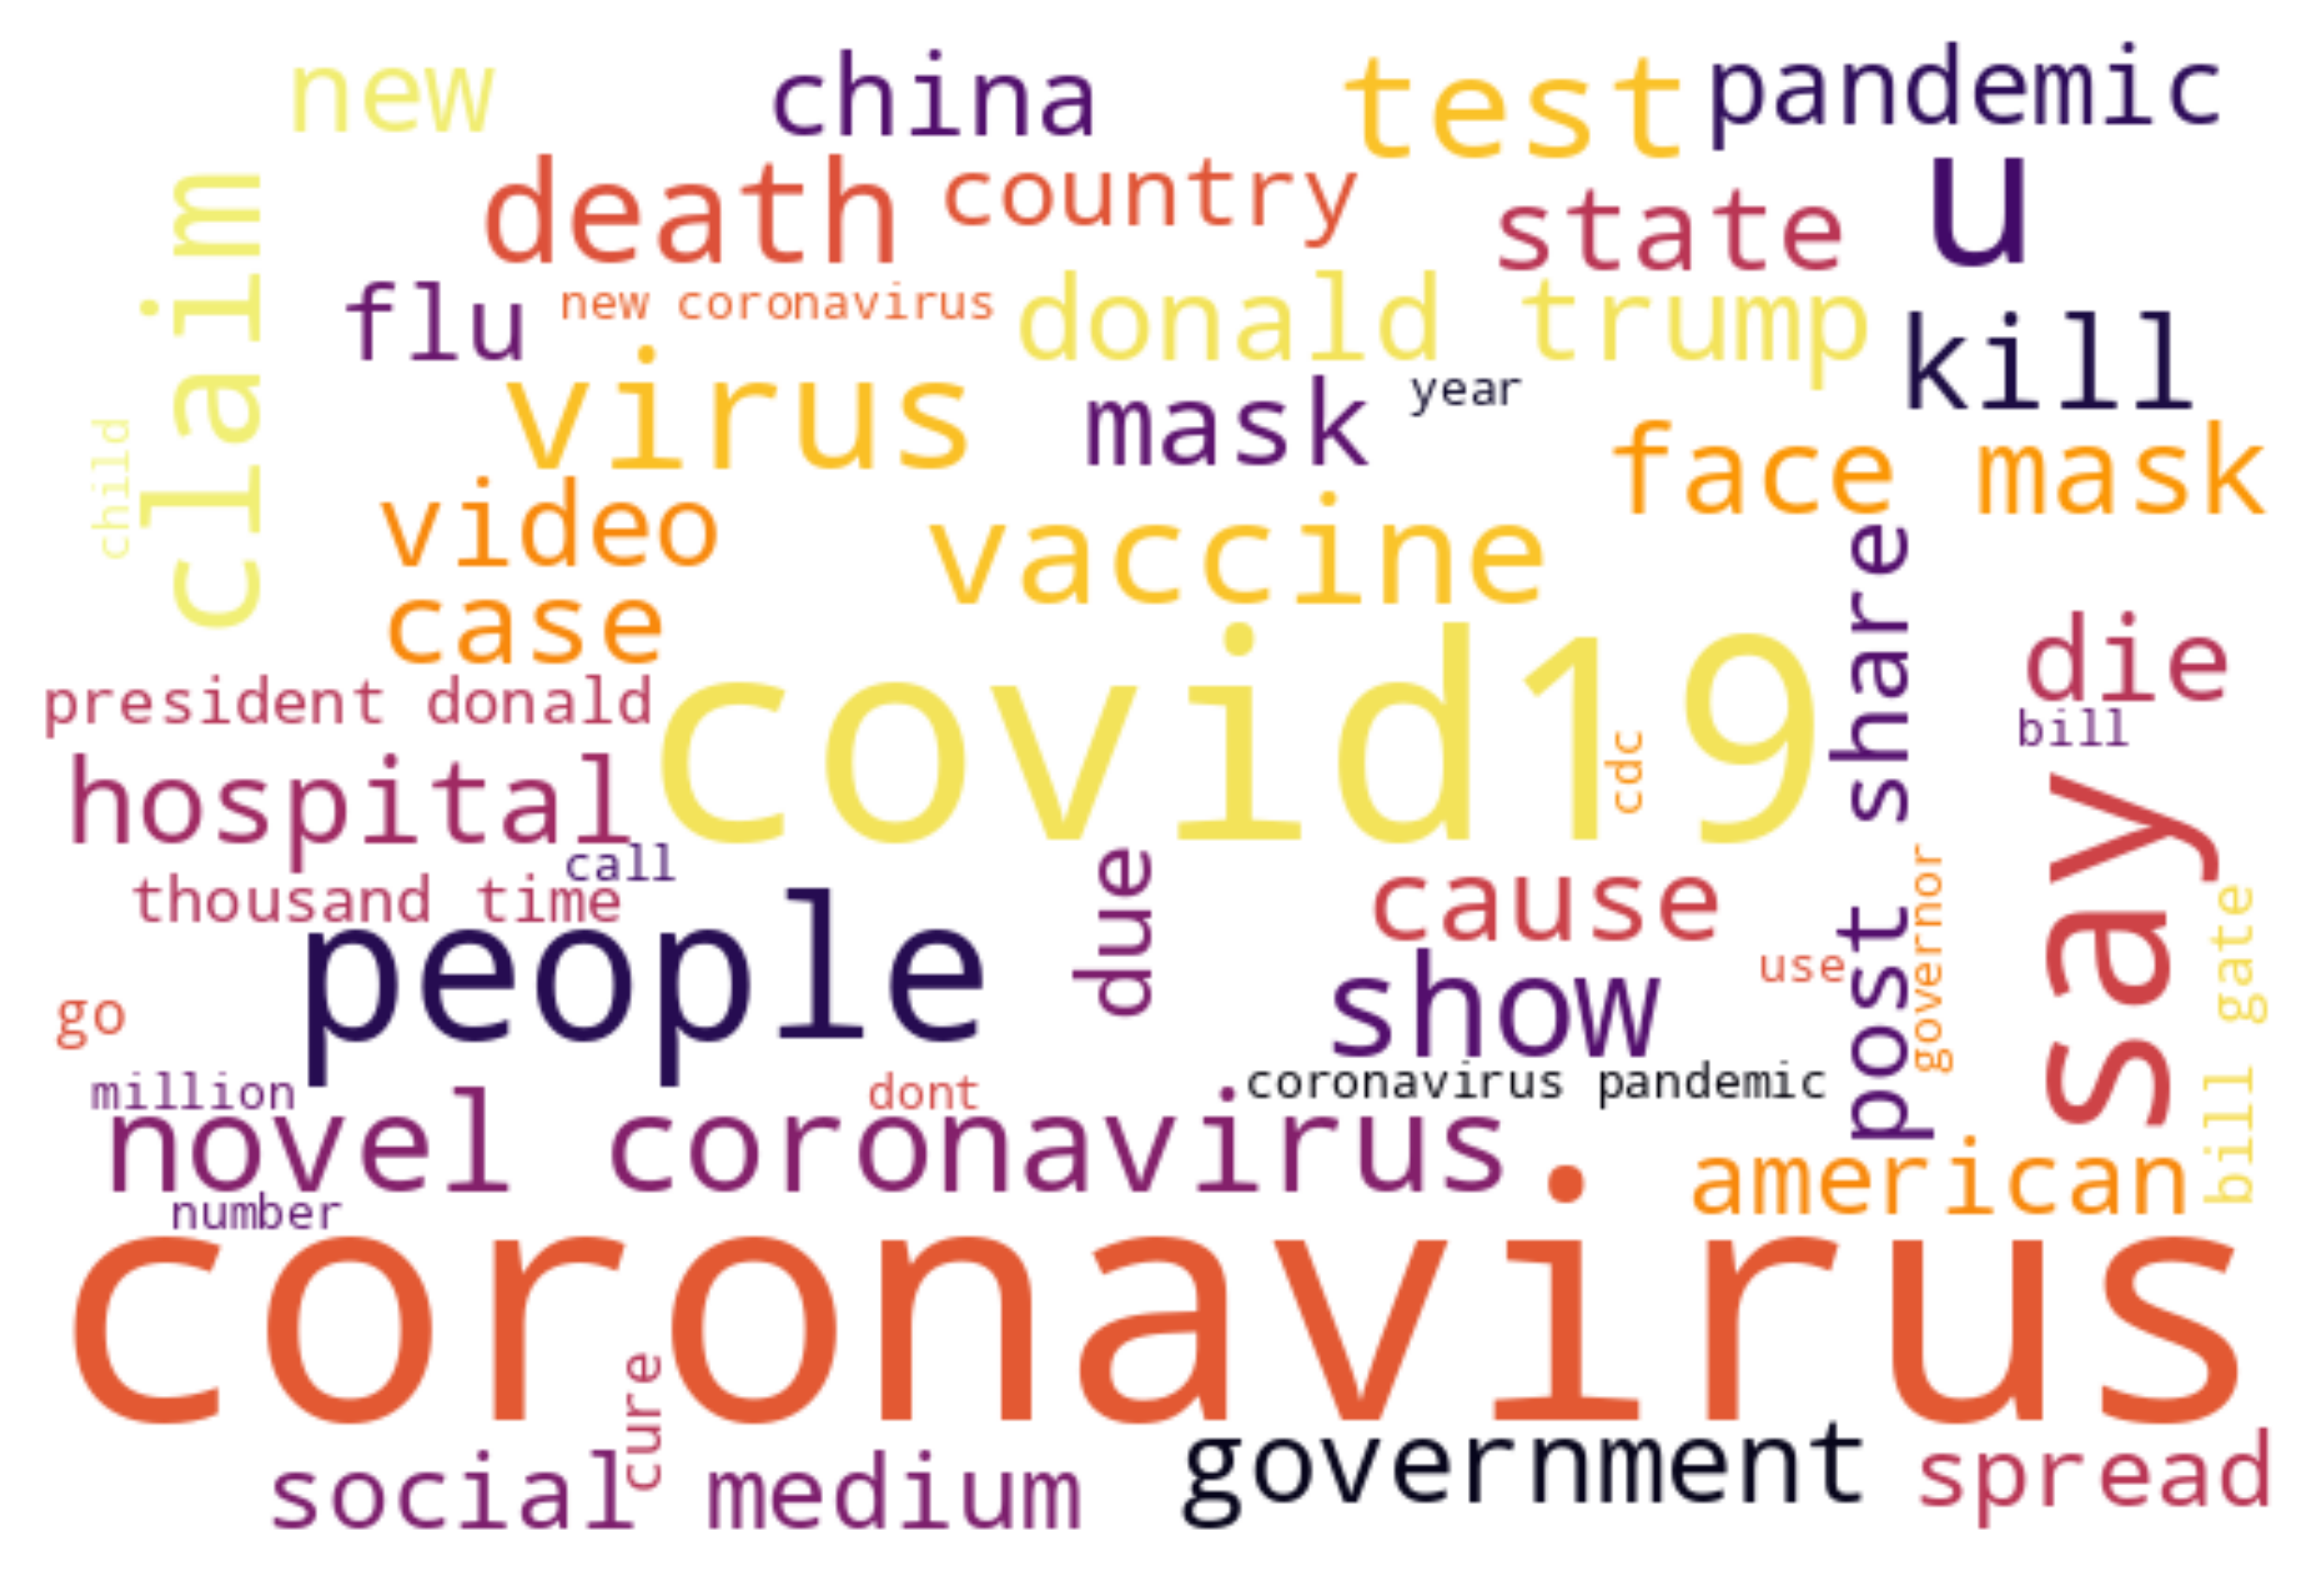

In [34]:
wordcloud = WordCloud(width=600, height=400, max_font_size=100, max_words=50, background_color="white", colormap="inferno").generate(text_fake_news_df_2)
plt.figure(figsize=(10, 5), dpi=450)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

####5.1. Gráfico de barras palavra X frequência

#####5.1.1 Dataset 1

######5.1.1.1 Real news

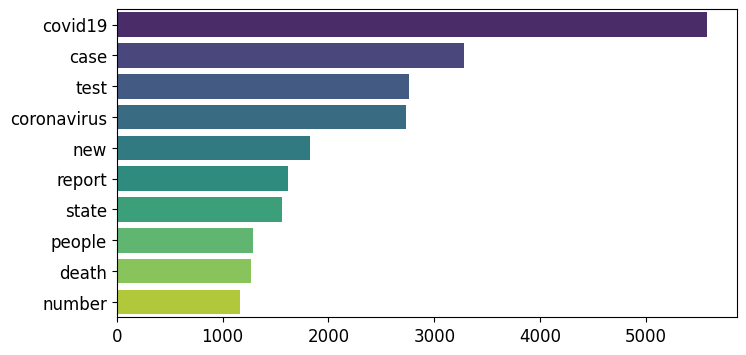

In [ ]:
word_count_real_df_1 = Counter(text_df_1.split())
common_words_real_df_1 = dict(word_count_real_df_1.most_common(10))
df_1_common_words_real = pd.DataFrame(list(common_words_real_df_1.items()), columns=['Palavra', 'Frequência'])
plt.figure(figsize=(8, 4))
sns.barplot(x='Frequência', y='Palavra', data=df_1_common_words_real, palette='viridis')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

######5.1.1.2 Fake news

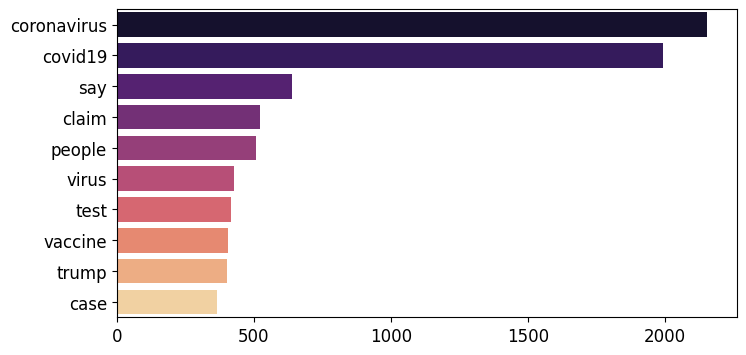

In [ ]:
word_count_fake_df_1 = Counter(text_fake_news_df_1.split())
common_words_fake_df_1 = dict(word_count_fake_df_1.most_common(10))
df_1_common_words_fake = pd.DataFrame(list(common_words_fake_df_1.items()), columns=['Palavra', 'Frequência'])
plt.figure(figsize=(8, 4))
sns.barplot(x='Frequência', y='Palavra', data=df_1_common_words_fake, palette='magma')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

#####5.1.2 Dataset 2

######5.1.2.1 Real news

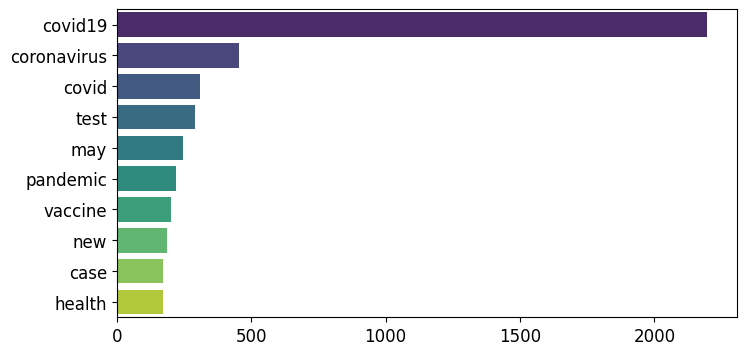

In [ ]:
word_count_real_df_2 = Counter(text_real_news_df_2.split())
common_words_real_df_2 = dict(word_count_real_df_2.most_common(10))
df_2_common_words_real = pd.DataFrame(list(common_words_real_df_2.items()), columns=['Palavra', 'Frequência'])
plt.figure(figsize=(8, 4))
sns.barplot(x='Frequência', y='Palavra', data=df_2_common_words_real, palette='viridis')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

######5.1.2.2 Fake News

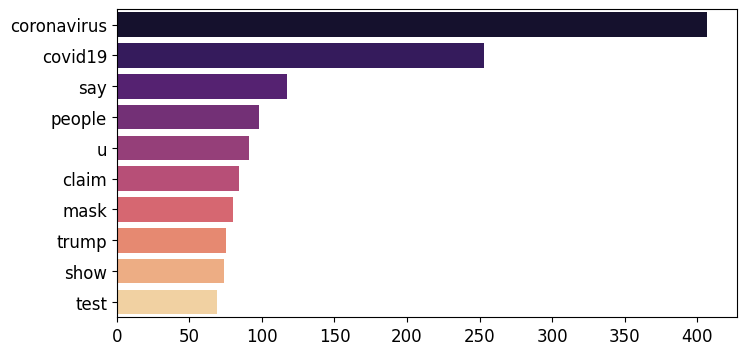

In [ ]:
word_count_fake_df_2 = Counter(text_fake_news_df_2.split())
common_words_fake_df_2 = dict(word_count_fake_df_2.most_common(10))
df_2_common_words_fake = pd.DataFrame(list(common_words_fake_df_2.items()), columns=['Palavra', 'Frequência'])
plt.figure(figsize=(8, 4))
sns.barplot(x='Frequência', y='Palavra', data=df_2_common_words_fake, palette='magma')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

###5. Tokenização

In [ ]:
def tokenize(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].apply(lambda x: word_tokenize(str(x)))
    return dataframe

In [ ]:
df_1_tokenized = tokenize(df_1, 'tweet')
df_2_tokenized = tokenize(df_2, 'title')

In [ ]:
df_1_tokenized.head()

###6. Classificador SVM

####6.1 Vetorização Dataset 1

In [ ]:
vectorizer_1 = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase=False)
vectorized_data_1 = vectorizer_1.fit_transform(df_1_tokenized['tweet'])

In [ ]:
vectorizer_1.get_feature_names_out()

#####6.1.1 Divisão dos dados Dataset 1

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(vectorized_data_1, df_1_tokenized['label'], test_size=0.25, random_state=42)

#####6.1.2 Treinamento Dataset 1

In [ ]:
svm_classifier_1 = LinearSVC(max_iter=3)
svm_classifier_1.fit(X_train_1, y_train_1)
y_pred_1 = svm_classifier_1.predict(X_test_1)

In [ ]:
print(classification_report(y_test_1, y_pred_1))

In [ ]:
conf_matrix_1 = confusion_matrix(y_test_1, y_pred_1)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier_1.classes_, yticklabels=svm_classifier_1.classes_)
plt.title('Matriz de Confusão COVID19 Fake News Detection in English')
plt.xlabel('Rótulo estimado')
plt.ylabel('Rótulo real')
plt.show()

####6.2 Vetorização Dataset 2

In [ ]:
vectorizer_2 = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase=False)
vectorized_data_2 = vectorizer_2.fit_transform(df_2_tokenized['title'])

In [ ]:
vectorizer_2.get_feature_names_out()

#####6.2.1 Divisão dos dados Dataset 2

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(vectorized_data_2, df_2_tokenized['label'], test_size=0.25, random_state=42)

#####6.2.1 Treinamento Dataset 2

In [ ]:
svm_classifier_2 = LinearSVC(max_iter=3)
svm_classifier_2.fit(X_train_2, y_train_2)
y_pred_2 = svm_classifier_2.predict(X_test_2)

In [ ]:
print(classification_report(y_test_2, y_pred_2))

In [ ]:
conf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier_2.classes_, yticklabels=svm_classifier_2.classes_)
plt.title('Matriz de Confusão CoAID')
plt.xlabel('Rótulo estimado')
plt.ylabel('Rótulo real')
plt.show()

###7. BERT

In [ ]:
!pip install transformers[torch]

In [ ]:
import transformers
import torch

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AdamW)

from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

optimizer = AdamW(bert_model.parameters(), lr=2e-5, eps=1e-8)

max_length = 256  # Definindo o comprimento máximo dos textos

bert_model.cuda()

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, column_name_text, column_name_label):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe[column_name_text].values
        self.targets = self.data[column_name_label].values
        self.max_len = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        # text = " ".join(text.split())  # Normalizar espaços em branco
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "token_type_ids": inputs["token_type_ids"],
            "labels": self.targets[index]
        }

#### Dataset 1

In [ ]:
bert_train_1, bert_test_1 = train_test_split(df_1, test_size=0.25, random_state=42)

train_dataset_1 = CustomDataset(bert_train_1, bert_tokenizer, max_length, 'tweet', 'label')
test_dataset_1 = CustomDataset(bert_test_1, bert_tokenizer, max_length, 'tweet', 'label')

In [ ]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset_1, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset_1, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
training_args = TrainingArguments(
    output_dir='./bert_classification',          # Diretório de saída para salvar checkpoints e resultados
    per_device_train_batch_size=BATCH_SIZE,   # Tamanho do lote por dispositivo para treinamento
    per_device_eval_batch_size=BATCH_SIZE,    # Tamanho do lote por dispositivo para avaliação
    num_train_epochs=3,              # Número de épocas de treinamento
    weight_decay=0.01,               # Decaimento do peso
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',            # Diretório para logs
)

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset_1,
    eval_dataset=test_dataset_1,
    compute_metrics=compute_metrics,
    tokenizer=bert_tokenizer
)

In [ ]:
trainer.train()

In [ ]:
results = trainer.evaluate()

In [ ]:
test_dataset_1.targets

In [ ]:
labels_list = test_dataset_1['label'].tolist()

In [ ]:
print(classification_report(test_dataset_1['label'], results['predictions'].argmax(axis=1)))